<a href="https://colab.research.google.com/github/amirmafzali/Neural_network-and-deep-learning_course/blob/main/AC_GAN%20on%20finger%20number%20dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import time 
import imageio
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf
import cv2
import keras
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [2]:
folder_dir = '/content/data1' 
a = [1,2,3,4,5]

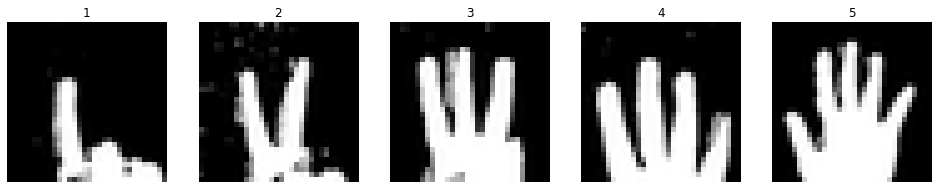

In [3]:
plt.figure(figsize=(20,20))
for i in a:
    plt.subplot(1, 6, i + 1)
    img = cv2.imread(folder_dir + '/' + str(i) + '/0.png',cv2.IMREAD_GRAYSCALE)
    plt.imshow(img,cmap='gray')
    plt.title(i)
    plt.axis('off')

In [4]:
images = []
label = []
for i in range(5):
  for j in range(201):
    img = cv2.imread(folder_dir + '/' + str(i+1) + '/' + str(j) + '.png',cv2.IMREAD_GRAYSCALE)
    if img is not None:
        images.append(img)
        label.append(i)
label = np.array(label)
label = keras.utils.to_categorical(label)
images = np.array(images).astype('float32')
images = images / 255
images = (images*2) - 1
print('shape of images of datset = ',images.shape)
print('shape of label of datset  = ',label.shape)

shape of images of datset =  (1005, 32, 32)
shape of label of datset  =  (1005, 5)


In [5]:
def generator(noise_input,label_input):

    x = keras.layers.Concatenate()([noise_input, label_input])
    x = Dense(units = 1024,input_shape=(100 + 5,))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(units = 4096)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Reshape(target_shape = (4, 4, 256))(x)                                                        
    x = Conv2DTranspose(filters = 256,kernel_size = 3,strides = 2,use_bias = False,padding = "SAME")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(filters = 128,kernel_size = 3,strides = 2,use_bias = False,padding = "SAME")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(filters = 1,kernel_size = 3,strides = 2,use_bias = False,padding = "SAME")(x) 
    x = BatchNormalization()(x)
    y = Activation("tanh")(x)

    model = Model([noise_input,label_input],y,name='Generator')
    #model.summary()

    return model

In [6]:
def discriminator(inputs):

    input_img = inputs                                      
    x = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "SAME")(input_img) 
    x = LeakyReLU()(x)
    x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = "SAME")(x)        
    x = LeakyReLU()(x)
    x = Conv2D(filters = 256, kernel_size = 3, strides = 2, padding = "SAME")(x)      
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters = 1024, kernel_size = 3, strides = 1, padding = "SAME")(x)  
    x = LeakyReLU()(x)
    x = Conv2D(filters = 1024, kernel_size = 3, strides = 1, padding = "SAME")(x)    
    x = LeakyReLU()(x)
    x = Conv2D(filters = 1024, kernel_size = 3, strides = 1, padding = "SAME")(x)      
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(units  =  1024)(x) 
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    y = Flatten()(x)

    x1 = Dense(1)(y)
    y1 = Activation('sigmoid')(x1)

    x2 = Dense(128)(y)
    y2 = Activation('relu')(x2)
    x3 = Dense(5)(y2)
    y3 = Activation('softmax')(x3)

    model = Model(inputs,[y1,y3],name='Discriminator')
    #model.summary()

    return model

In [7]:
def acgan():

    dis_inputs = Input(shape=(32,32,1))
    dis = discriminator(dis_inputs)
    dis.compile(loss=['binary_crossentropy','categorical_crossentropy'],
    optimizer=Adam(0.0002, 0.5),metrics=['accuracy'])

    gen_noise_inputs = Input(shape=(100,))
    gen_label_inputs = Input(shape=(5,))
    gen = generator(gen_noise_inputs,gen_label_inputs)

    dis.trainable = False
    acgan_inputs = [gen_noise_inputs,gen_label_inputs]
    acgan_output = dis(gen(acgan_inputs))
    acgan = Model(acgan_inputs,acgan_output,name='Acgan')
    acgan.compile(loss=['binary_crossentropy','categorical_crossentropy'],
                  optimizer=Adam(0.0002, 0.5),metrics=['accuracy'])
    
    #acgan.summary()
    models = gen, dis, acgan
    history = train(models)

    return history 

In [84]:
def train(models):

    gen, dis, acgan = models

    epochs = 1000
    batch_size = 100
    noise_shape=100

    dis_loss = []
    dis_rf_loss = []
    dis_label_loss = []
    dis_rf_accu = []
    dis_label_accu = []

    acgan_loss = []
    acgan_rf_loss = []
    acgan_label_loss = []
    acgan_rf_accu = []
    acgan_label_accu = []

    for epoch in range(epochs):
      for i in range(images.shape[0]//batch_size):
        #Fake image generate
        noise = np.random.normal(size=[batch_size,noise_shape])
        fake_class_label = np.eye(5)[np.arange(batch_size)%5]
        fake_real_or_fake_label = np.zeros((batch_size,1))
        fake_image = gen.predict([noise,fake_class_label])
        #Real image dividation
        real_image = images[i*batch_size:(i+1)*batch_size].reshape(-1,32,32,1)
        real_class_label = label[i*batch_size:(i+1)*batch_size]
        real_real_or_fake_label = np.ones((batch_size,1))
        #Concatenate for discriminator input
        disc_images = np.concatenate([real_image,fake_image])  
        disc_real_or_fake_label = np.concatenate([real_real_or_fake_label,fake_real_or_fake_label])
        disc_class_label = np.concatenate([real_class_label,fake_class_label])
        #Train discriminator
        dis_loss0,dis_rf_loss0,dis_label_loss0,dis_rf_accu0,dis_label_accu0 = dis.train_on_batch(disc_images,[disc_real_or_fake_label,disc_class_label])
        #AC-GAN input and output
        acgan_input = [noise,fake_class_label]
        acgan_output = [real_real_or_fake_label,fake_class_label]
        #Train AC-GAN 
        acgan_loss0,acgan_rf_loss0,acgan_label_loss0,acgan_rf_accu0,acgan_label_accu0 = acgan.train_on_batch(acgan_input,acgan_output)
      #Loss and accuracy appending
      dis_loss.append(dis_loss0)
      dis_rf_loss.append(dis_rf_loss0)
      dis_label_loss.append(dis_label_loss0)
      dis_rf_accu.append(dis_rf_accu0*100)
      dis_label_accu.append(dis_label_accu0*100)
      acgan_loss.append(acgan_loss0)
      acgan_rf_loss.append(acgan_rf_loss0)
      acgan_label_loss.append(acgan_label_loss0)
      acgan_rf_accu.append(acgan_rf_accu0*100)
      acgan_label_accu.append(acgan_label_accu0*100)
      #Plot images
      if (epoch+1)%20 == 0:
        print('Epoch = ',str(epoch+1))
        test_label = np.eye(5)
        fake_image = gen.predict([np.random.normal(size=(5,100)),test_label])
        for k in range(5):
          plt.subplot(1,5,k+1)
          plt.imshow(fake_image[k].reshape(32,32),cmap='gray')
          plt.axis('off')
        plt.show()

    return dis_loss,dis_rf_loss,dis_label_loss,dis_rf_accu,dis_label_accu,acgan_loss,acgan_rf_loss,acgan_label_loss,acgan_rf_accu,acgan_label_accu

4/4 [==============================] - 0s 4ms/step
Epoch =  20
1/1 [==============================] - 0s 16ms/step


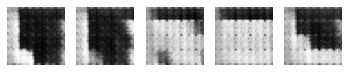

4/4 [==============================] - 0s 3ms/step
Epoch =  40
1/1 [==============================] - 0s 14ms/step


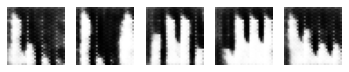

4/4 [==============================] - 0s 4ms/step
Epoch =  60
1/1 [==============================] - 0s 18ms/step


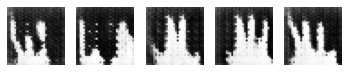

4/4 [==============================] - 0s 4ms/step
Epoch =  80
1/1 [==============================] - 0s 16ms/step


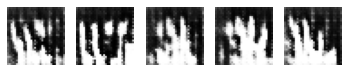

4/4 [==============================] - 0s 4ms/step
Epoch =  100
1/1 [==============================] - 0s 16ms/step


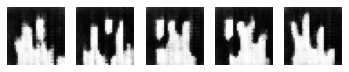

4/4 [==============================] - 0s 4ms/step
Epoch =  120
1/1 [==============================] - 0s 18ms/step


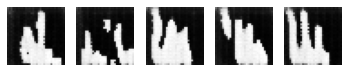

4/4 [==============================] - 0s 5ms/step
Epoch =  140
1/1 [==============================] - 0s 15ms/step


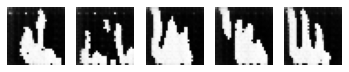

4/4 [==============================] - 0s 6ms/step
Epoch =  160
1/1 [==============================] - 0s 14ms/step


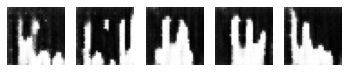

4/4 [==============================] - 0s 4ms/step
Epoch =  180
1/1 [==============================] - 0s 15ms/step


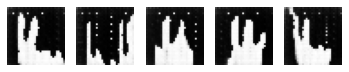

4/4 [==============================] - 0s 4ms/step
Epoch =  200
1/1 [==============================] - 0s 20ms/step


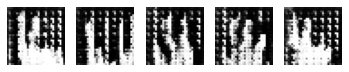

4/4 [==============================] - 0s 3ms/step
Epoch =  220
1/1 [==============================] - 0s 16ms/step


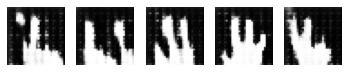

4/4 [==============================] - 0s 4ms/step
Epoch =  240
1/1 [==============================] - 0s 16ms/step


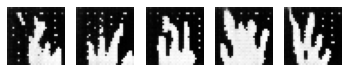

4/4 [==============================] - 0s 5ms/step
Epoch =  260
1/1 [==============================] - 0s 21ms/step


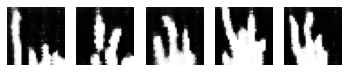

4/4 [==============================] - 0s 5ms/step
Epoch =  280
1/1 [==============================] - 0s 15ms/step


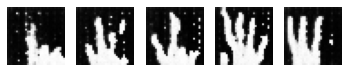

4/4 [==============================] - 0s 7ms/step
Epoch =  300
1/1 [==============================] - 0s 16ms/step


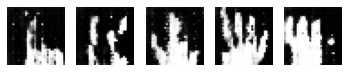

4/4 [==============================] - 0s 5ms/step
Epoch =  320
1/1 [==============================] - 0s 19ms/step


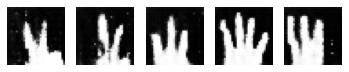

4/4 [==============================] - 0s 5ms/step
Epoch =  340
1/1 [==============================] - 0s 16ms/step


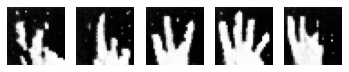

4/4 [==============================] - 0s 6ms/step
Epoch =  360
1/1 [==============================] - 0s 15ms/step


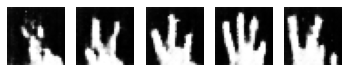

4/4 [==============================] - 0s 3ms/step
Epoch =  380
1/1 [==============================] - 0s 17ms/step


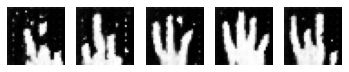

4/4 [==============================] - 0s 4ms/step
Epoch =  400
1/1 [==============================] - 0s 15ms/step


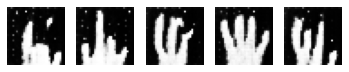

4/4 [==============================] - 0s 4ms/step
Epoch =  420
1/1 [==============================] - 0s 16ms/step


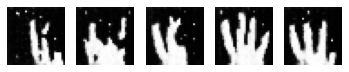

4/4 [==============================] - 0s 4ms/step
Epoch =  440
1/1 [==============================] - 0s 14ms/step


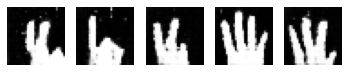

4/4 [==============================] - 0s 5ms/step
Epoch =  460
1/1 [==============================] - 0s 16ms/step


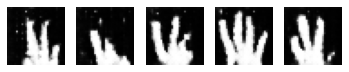

4/4 [==============================] - 0s 4ms/step
Epoch =  480
1/1 [==============================] - 0s 15ms/step


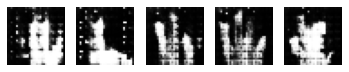

4/4 [==============================] - 0s 4ms/step
Epoch =  500
1/1 [==============================] - 0s 18ms/step


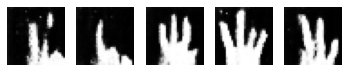

4/4 [==============================] - 0s 4ms/step
Epoch =  520
1/1 [==============================] - 0s 15ms/step


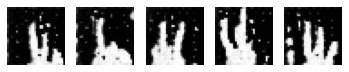

4/4 [==============================] - 0s 4ms/step
Epoch =  540
1/1 [==============================] - 0s 15ms/step


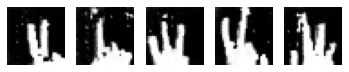

4/4 [==============================] - 0s 5ms/step
Epoch =  560
1/1 [==============================] - 0s 18ms/step


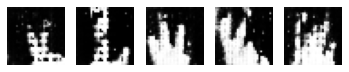

4/4 [==============================] - 0s 4ms/step
Epoch =  580
1/1 [==============================] - 0s 15ms/step


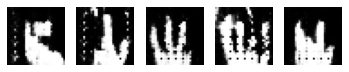

4/4 [==============================] - 0s 6ms/step
Epoch =  600
1/1 [==============================] - 0s 15ms/step


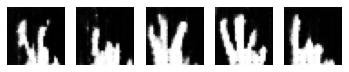

4/4 [==============================] - 0s 4ms/step
Epoch =  620
1/1 [==============================] - 0s 16ms/step


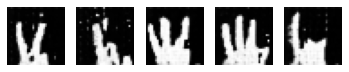

4/4 [==============================] - 0s 6ms/step
Epoch =  640
1/1 [==============================] - 0s 16ms/step


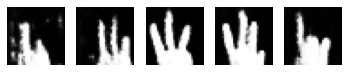

4/4 [==============================] - 0s 3ms/step
Epoch =  660
1/1 [==============================] - 0s 15ms/step


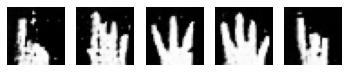

4/4 [==============================] - 0s 4ms/step
Epoch =  680
1/1 [==============================] - 0s 15ms/step


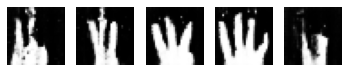

4/4 [==============================] - 0s 6ms/step
Epoch =  700
1/1 [==============================] - 0s 16ms/step


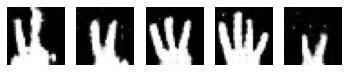

4/4 [==============================] - 0s 4ms/step
Epoch =  720
1/1 [==============================] - 0s 15ms/step


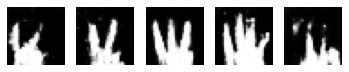

4/4 [==============================] - 0s 6ms/step
Epoch =  740
1/1 [==============================] - 0s 18ms/step


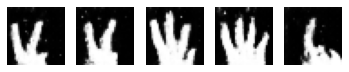

4/4 [==============================] - 0s 3ms/step
Epoch =  760
1/1 [==============================] - 0s 17ms/step


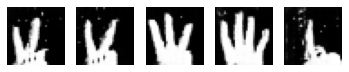

4/4 [==============================] - 0s 4ms/step
Epoch =  780
1/1 [==============================] - 0s 16ms/step


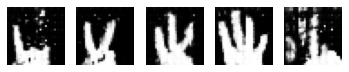

4/4 [==============================] - 0s 3ms/step
Epoch =  800
1/1 [==============================] - 0s 16ms/step


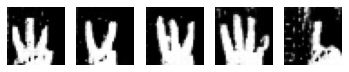

4/4 [==============================] - 0s 7ms/step
Epoch =  820
1/1 [==============================] - 0s 21ms/step


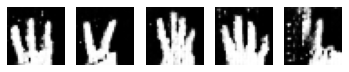

4/4 [==============================] - 0s 4ms/step
Epoch =  840
1/1 [==============================] - 0s 17ms/step


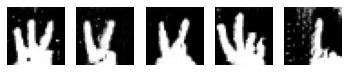

4/4 [==============================] - 0s 3ms/step
Epoch =  860
1/1 [==============================] - 0s 16ms/step


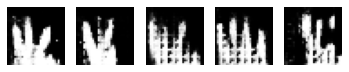

4/4 [==============================] - 0s 6ms/step
Epoch =  880
1/1 [==============================] - 0s 15ms/step


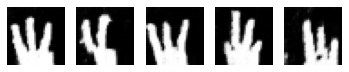

4/4 [==============================] - 0s 3ms/step
Epoch =  900
1/1 [==============================] - 0s 15ms/step


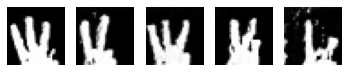

4/4 [==============================] - 0s 6ms/step
Epoch =  920
1/1 [==============================] - 0s 16ms/step


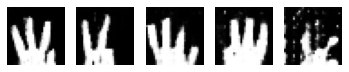

4/4 [==============================] - 0s 4ms/step
Epoch =  940
1/1 [==============================] - 0s 16ms/step


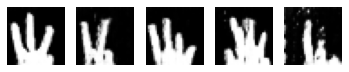

4/4 [==============================] - 0s 4ms/step
Epoch =  960
1/1 [==============================] - 0s 17ms/step


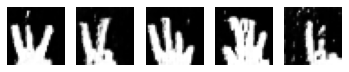

4/4 [==============================] - 0s 4ms/step
Epoch =  980
1/1 [==============================] - 0s 15ms/step


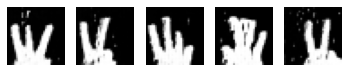

4/4 [==============================] - 0s 6ms/step
Epoch =  1000
1/1 [==============================] - 0s 15ms/step


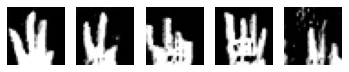

In [85]:
history = acgan()

In [91]:
dis_loss,dis_rf_loss,dis_label_loss,dis_rf_accu,dis_label_accu,acgan_loss,acgan_rf_loss,acgan_label_loss,acgan_rf_accu,acgan_label_accu = history

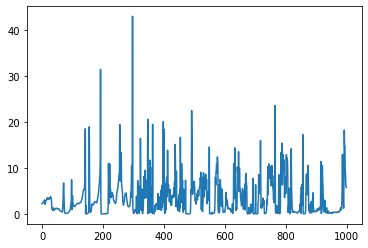

In [92]:
plt.plot(acgan_loss)

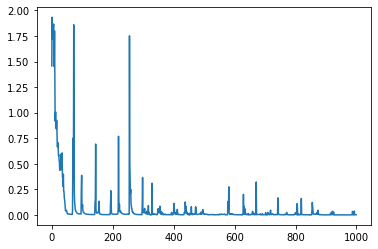

In [93]:
plt.plot(dis_loss)

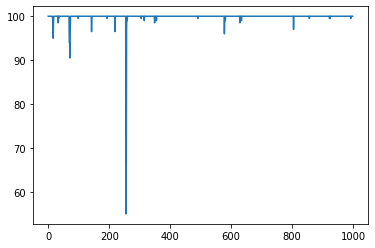

In [94]:
plt.plot(dis_rf_accu)

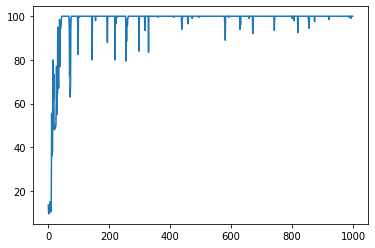

In [95]:

plt.plot(dis_label_accu)